#### __Import Libraries__

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

#### __Neural Net Model__

In [2]:
class Neural_Network():
    def __init__(self, learning_rate, X_train, y_train):

        self.learning_rate = learning_rate

        self.layer_size = []
        self.layer_type = []
        self.num_of_layers = -1
        self.act_fct_type = []

        self.input_size = len(X_train[0])
        self.output_size = len(y_train[0])
        self.X_train = X_train
        self.y_train = y_train
        self.N = len(y_train)

        self.Wdict = {}
        self.Zdict = {}
        self.Adict = {}
        self.dWdict = {}

    def activation_forward(self, x, type):
        if type == "sigmoid":
            return 1 / (1 + np.exp(-x))
        elif type == "ReLU":
            return np.maximum(0, x)
        elif type == "tanh":
            return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
        elif type == "softmax":
            return np.exp(x) / np.sum(np.exp(x))


    def actiovation_backward(self, x, type):
        if type == "sigmoid":
            return x * (1 - x)
        elif type == "ReLU":
            return np.where(x > 0, 1.0, 0.0)
        elif type == "tanh":
            return 1-x**2


    def mean_squared_error(self, pred, act):
        return np.mean(np.square(act - pred))

    def accuracy(self, pred, act):
        acc = pred.argmax(axis=1) == act.argmax(axis=1)
        return acc.mean()

    def add_layer(self, type, act_fct, size=None):
        np.random.seed(10)
        self.act_fct_type.append(act_fct)
        self.layer_type.append(type)

        if type == "input":
            self.layer_size.append(size)
            self.num_of_layers += 1
            self.Wdict[self.num_of_layers] = np.random.normal(scale=0.5, size=(self.input_size, size))

        elif type == "hidden":
            self.num_of_layers += 1
            self.Wdict[self.num_of_layers] = np.random.normal(scale=0.5,
                                                              size=(self.layer_size[len(self.layer_size) - 1], size))
            self.layer_size.append(size)

        elif type == "output":
            self.num_of_layers += 1
            self.Wdict[self.num_of_layers] = np.random.normal(scale=0.5,
                                                              size=(self.layer_size[len(self.layer_size) - 1],
                                                                    self.output_size))
            self.layer_size.append(self.output_size)

    def forward_pass(self, X_data):
        for i in range(self.num_of_layers + 1):
            if self.layer_type[i] == "input":
                self.Zdict[i] = np.dot(X_data, self.Wdict[i])
                self.Adict[i] = self.activation_forward(self.Zdict[i], self.act_fct_type[i])

            elif self.layer_type[i] == "hidden" or self.layer_type[i] == "output":
                self.Zdict[i] = np.dot(self.Adict[i - 1], self.Wdict[i])
                self.Adict[i] = self.activation_forward(self.Zdict[i], self.act_fct_type[i])

        return self.Adict[self.num_of_layers]

    def backward_pass(self):
        for i in range(self.num_of_layers, -1, -1):
            if self.layer_type[i] == "output":
                E = self.Adict[i] - self.y_train
                self.dWdict[i] = E * self.actiovation_backward(self.Adict[i], self.act_fct_type[i])
                self.Wdict[i] = self.Wdict[i] - self.learning_rate * (
                        np.dot(self.Adict[i - 1].T, self.dWdict[i]) / self.N)

            elif self.layer_type[i] == "hidden" or self.layer_type[i] == "input":
                E = np.dot(self.dWdict[i + 1], self.Wdict[i + 1].T)
                self.dWdict[i] = E * self.actiovation_backward(self.Adict[i], self.act_fct_type[i])
                if self.layer_type[i] == "hidden":
                    self.Wdict[i] = self.Wdict[i] - self.learning_rate * (
                            np.dot(self.Adict[i - 1].T, self.dWdict[i]) / self.N)
                else:
                    self.Wdict[i] = self.Wdict[i] - self.learning_rate * (
                            np.dot(self.X_train.T, self.dWdict[i]) / self.N)

    def train(self, X_data):
        self.forward_pass(X_data)
        self.backward_pass()

    def plot_error_accuracy(self, err_values, acc_values):
        plt.plot(np.arange(len(err_values)), err_values, label="error")
        plt.plot(np.arange(len(acc_values)), acc_values, label="accuracy")
        plt.title('Error & Accuracy over Time')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()

#### __Model Training__

#0
Loss: 0.37621514450966603

#1000
Loss: 0.06136903477326052

#2000
Loss: 0.050426937543116855

#3000
Loss: 0.04463625657074571

#4000
Loss: 0.04051423834207194

#5000
Loss: 0.03725333436950859

#6000
Loss: 0.03453873866900778

#7000
Loss: 0.032266071560885665

#8000
Loss: 0.030350640754143062

#9000
Loss: 0.028726529177380524

#10000
Accuracy_Training: 1.0
Accuracy: 1.0


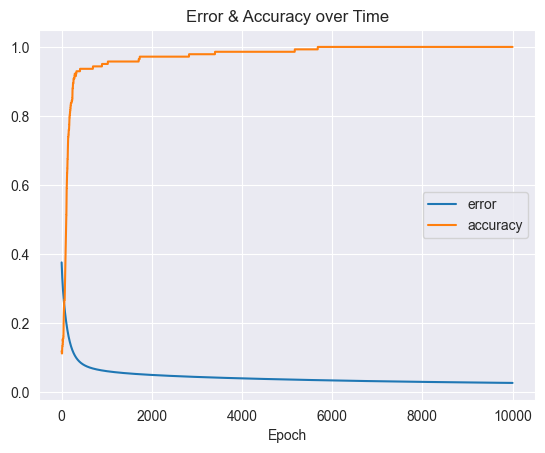

In [3]:
data = load_wine()
X = data.data
y = data.target
y = pd.get_dummies(y).values
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)
iterations = 10_000
err_values = []
acc_values = []

NN = Neural_Network(0.01, X_train, y_train)
NN.add_layer("input", "tanh", 13)
NN.add_layer("hidden", "sigmoid", 16)
NN.add_layer("output", "tanh", 3)

for itr in range(iterations):
    NN.train(X_train)
    err_values.append(NN.mean_squared_error(NN.forward_pass(X_train), y_train))
    acc_values.append(NN.accuracy(NN.forward_pass(X_train), y_train))

    if itr % 1000 == 0:
        print("#" + str(itr))
        print("Loss: " + str(NN.mean_squared_error(NN.forward_pass(X_train), y_train)) + "\n")

print("#" + str(iterations))
print("Accuracy_Training: " + str(NN.accuracy(NN.forward_pass(X_train), y_train)))

print("Accuracy: " + str(NN.accuracy(NN.forward_pass(X_test), y_test)))

NN.plot_error_accuracy(err_values, acc_values)

#### __Confusion Matrix__

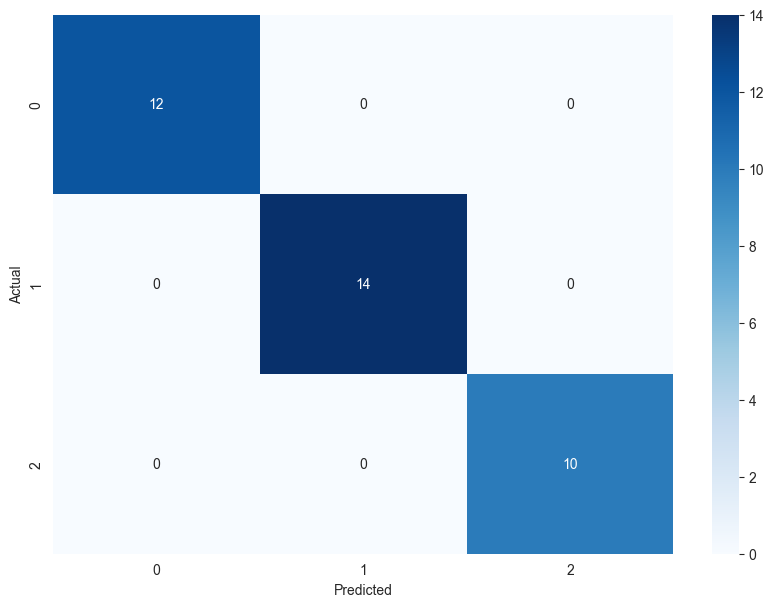

In [4]:
pred = NN.forward_pass(X_test)
matrix_pred = list()
matrix_true = list()
for idx in range(len(pred)):
    matrix_pred.append(np.argmax(pred[idx]))
    matrix_true.append(np.argmax(y_test[idx]))

cm = confusion_matrix(matrix_true, matrix_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()